
# 📈 Portfolio Analysis

This notebook loads a **portfolio** (ticker + quantity), fetches historical prices from **Alpha Vantage**, 
computes **daily portfolio value**, and compares it to a **benchmark** (BOVA11.SAO as IBOV proxy).

### Goal:
- Robust data fetching with **API key from .env**, retries, and simple **local caching**
- Clean alignment of trading calendars and closing prices
- Clear plots for benchmark vs. portfolio


In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
from alpha_vantage.timeseries import TimeSeries
from datetime import date, timedelta
import time
import pandas as pd

# Paths
DATA_DIR = Path("./data_cache")        # where raw API responses are cached as CSV
DATA_DIR.mkdir(exist_ok=True)
PORTFOLIO_PATH = Path("portfolio.xlsx") 
BENCHMARK = "BOVA11"   # IBOV proxy
START_DATE = None
END_DATE   = None

# Alpha Vantage API (free tier: 5 req/min; 500/day)
load_dotenv()
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY") or os.getenv("ALPHA_VANTAGE_API_KEY")
if not API_KEY:
    raise RuntimeError("Alpha Vantage API key not found. Create a .env with ALPHAVANTAGE_API_KEY=<your_key>")

ts = TimeSeries(key=API_KEY, output_format='pandas')
print("Config OK. Cache dir:", DATA_DIR.resolve())

Config OK. Cache dir: /Users/ferfilho/Desktop/Machine Learning/datatalks/module-1/projects/data_cache


In [2]:
def fetch_daily_closed(symbol: str, sleep_sec: float = 12.0):
    """Fetches daily adjusted close prices for a given symbol from Alpha Vantage API.
    Caches the result as CSV in DATA_DIR to avoid redundant API calls.
    Respects free tier rate limits by sleeping between calls.
    """

    # Check cache first
    cache_path = DATA_DIR / f"{symbol}.csv"
    if cache_path.exists():
        print(f"Loading cached data for {symbol} from {cache_path}")
        df = pd.read_csv(cache_path, index_col='date', parse_dates=True)
        return df

    print(f"Fetching data for {symbol} from Alpha Vantage API...")
    try:
        data, meta_data = ts.get_daily(symbol=f'{symbol}.SAO', outputsize='full')
        df = data[['4. close']].rename(columns={'4. close': symbol})
        df.index.name = 'date'
        df.to_csv(cache_path) # Cache the data
        print(f"Data for {symbol} cached at {cache_path}")
        time.sleep(sleep_sec)  # Sleep to respect rate limits
        return df
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

def align_prices(price_cols: dict, start=None, end=None):
    """Combine multiple price Series into a single DataFrame with aligned dates.
    Forward-fills missing days after reindexing to the union of trading days.
    """
    df = pd.concat(price_cols.values(), axis=1)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    if start:
        df = df[df.index >= pd.to_datetime(start)]
    if end:
        df = df[df.index <= pd.to_datetime(end)]
    # Forward fill to handle non-overlapping exchange holidays; drop rows with all NaNs
    df = df.ffill().dropna(how='all')
    return df


## 1) Load Portfolio

In [3]:
portfolio = pd.read_excel(PORTFOLIO_PATH)
display(portfolio)


,stocks,initial_investment
0,ITUB4,10000
1,ABEV3,10000
2,VALE3,10000
3,BBDC3,10000


## 2) Fetch Prices (cached)

In [4]:
# --- Fetch prices for portfolio tickers and benchmark (cached) ---
symbols = portfolio['stocks'].unique().tolist()
symbols = [s.strip() for s in symbols if isinstance(s, str)]
all_symbols = sorted(set(symbols + [BENCHMARK]))

print("Fetching data for:", all_symbols)
stock_prices = {}
for i, sym in enumerate(all_symbols, 1):
    print(f"[{i}/{len(all_symbols)}] Fetching {sym} ...")
    s = fetch_daily_closed(sym)
    stock_prices[sym] = s

Fetching data for: ['ABEV3', 'BBDC3', 'BOVA11', 'ITUB4', 'VALE3']
[1/5] Fetching ABEV3 ...
Loading cached data for ABEV3 from data_cache/ABEV3.csv
[2/5] Fetching BBDC3 ...
Loading cached data for BBDC3 from data_cache/BBDC3.csv
[3/5] Fetching BOVA11 ...
Loading cached data for BOVA11 from data_cache/BOVA11.csv
[4/5] Fetching ITUB4 ...
Loading cached data for ITUB4 from data_cache/ITUB4.csv
[5/5] Fetching VALE3 ...
Loading cached data for VALE3 from data_cache/VALE3.csv


In [5]:
# --- Align prices into a single DataFrame ---
stock_prices_df = align_prices(stock_prices, start=START_DATE, end=END_DATE)
display(stock_prices_df)

,ABEV3,BBDC3,BOVA11,ITUB4,VALE3
date,,,,,
2005-01-03,NaN,55.6663,NaN,408.0083,74.85
2005-01-04,NaN,53.6881,NaN,402.9993,71.80
2005-01-05,NaN,51.6997,NaN,399.0000,71.30
2005-01-06,NaN,50.2064,NaN,393.9976,71.00
2005-01-07,NaN,51.3007,NaN,393.4993,72.90
...,...,...,...,...,...
2025-09-29,12.41,15.2800,143.45,38.8900,57.28
2025-09-30,12.09,15.2300,143.24,39.0700,57.58
2025-10-01,11.99,14.9300,142.52,38.3500,58.31


In [6]:
# --- Compute stock quantities from initial invested cash at START_DATE ---
# Determine start date for quantity calculation:
# - If START_DATE is set, use it.
# - Otherwise, use the latest first-available date across all selected symbols (max of each first index).
if START_DATE is not None:
    start_date = pd.to_datetime(START_DATE)
else:
    first_dates = []
    for sym in symbols:
        s = stock_prices_df[sym].dropna()
        if not s.empty:
            first_dates.append(s.index.min()) # first available date for this symbol
    if not first_dates:
        raise RuntimeError("No price data found to infer start date.")
    start_date = max(first_dates) # latest of the first available dates
    
if END_DATE is not None:
    end_date = pd.to_datetime(END_DATE)
else:
    end_date = stock_prices_df.index.max()  # latest available date

print("Portfolio creation date:", start_date.date())
print("Portfolio last updated on:", end_date.date())

# Restrict stock_prices_df to the date range for easier plotting later
stock_prices_df = stock_prices_df.loc[start_date:end_date]

Portfolio creation date: 2013-05-13
Portfolio last updated on: 2025-10-03


In [7]:
# Calculate initial stock quantities based on initial cash and prices at start_date
for stock in portfolio['stocks']:
    portfolio.loc[portfolio['stocks'] == stock, 'qty'] = portfolio.loc[portfolio['stocks'] == stock, 'initial_investment'].values / stock_prices_df.loc[start_date, stock]

display(portfolio)

,stocks,initial_investment,qty
0,ITUB4,10000,294.031167
1,ABEV3,10000,118.021952
2,VALE3,10000,299.043062
3,BBDC3,10000,299.137885


<Axes: title={'center': 'Stock Closing Prices'}, xlabel='date'>

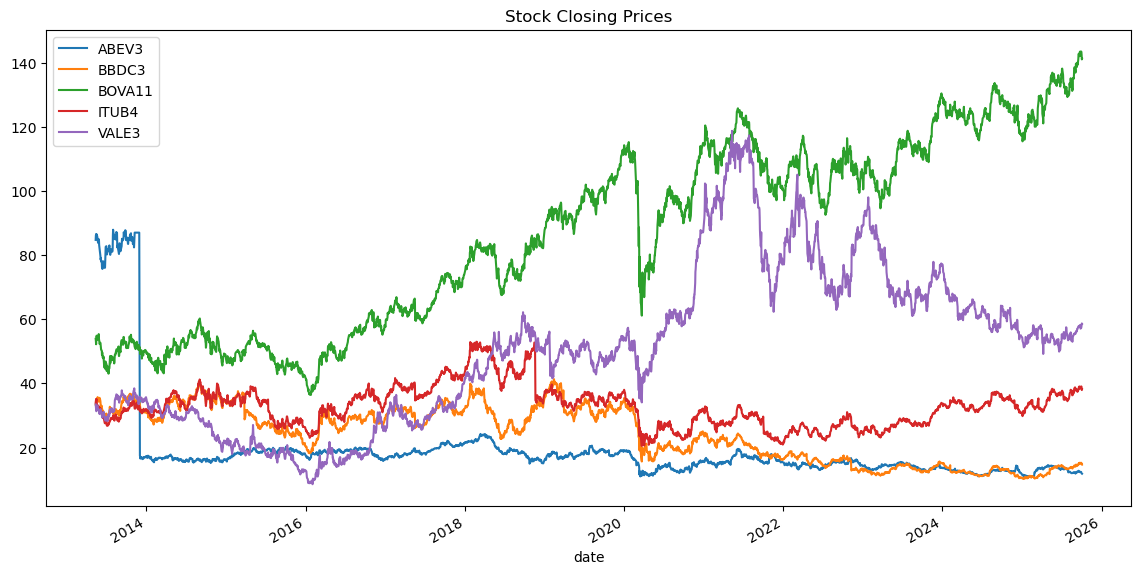

In [8]:
# Plot Stock Prices
stock_prices_df.plot(title='Stock Closing Prices', figsize=(14, 7))

In [9]:
# Calculate the portfolio total value over time
portfolio_closed_prices = stock_prices_df[symbols]
benchmark = stock_prices_df[[BENCHMARK]].rename(columns={BENCHMARK: 'IBOV'})
portfolio_total_value = pd.DataFrame()

for stock in portfolio_closed_prices.columns:
    # multiply each stock’s daily close price by its quantity
    qty = portfolio.loc[portfolio['stocks'] == stock, 'qty'].values[0]
    portfolio_total_value[stock] = stock_prices_df[stock] * qty

portfolio_total_value['Total'] = portfolio_total_value.sum(axis=1)

display(benchmark)
display(portfolio_closed_prices)
display(portfolio_total_value)

,IBOV
date,
2013-05-13,53.91
2013-05-14,53.30
2013-05-15,52.21
2013-05-16,53.78
2013-05-17,54.89
...,...
2025-09-29,143.45
2025-09-30,143.24
2025-10-01,142.52


,ITUB4,ABEV3,VALE3,BBDC3
date,,,,
2013-05-13,34.0100,84.73,33.44,33.4294
2013-05-14,34.5202,86.10,32.79,33.4197
2013-05-15,35.1003,86.50,32.10,33.6780
2013-05-16,34.7701,85.62,31.35,34.2155
2013-05-17,35.1300,86.53,31.77,34.5237
...,...,...,...,...
2025-09-29,38.8900,12.41,57.28,15.2800
2025-09-30,39.0700,12.09,57.58,15.2300
2025-10-01,38.3500,11.99,58.31,14.9300


,ITUB4,ABEV3,VALE3,BBDC3,Total
date,,,,,
2013-05-13,10000.000000,10000.000000,10000.000000,10000.000000,40000.000000
2013-05-14,10150.014702,10161.690074,9805.622010,9997.098363,40114.425148
2013-05-15,10320.582182,10208.898855,9599.282297,10074.365678,40203.129012
2013-05-16,10223.493090,10105.039537,9375.000000,10235.152291,39938.684919
2013-05-17,10329.314907,10212.439514,9500.598086,10327.346587,40369.699094
...,...,...,...,...,...
2025-09-29,11434.872096,1464.652425,17129.186603,4570.826877,34599.538002
2025-09-30,11487.797707,1426.885401,17218.899522,4555.869983,34689.452611
2025-10-01,11276.095266,1415.083205,17437.200957,4466.128617,34594.508046


<Axes: title={'center': 'Portfolio Total Value Over Time'}, xlabel='date'>

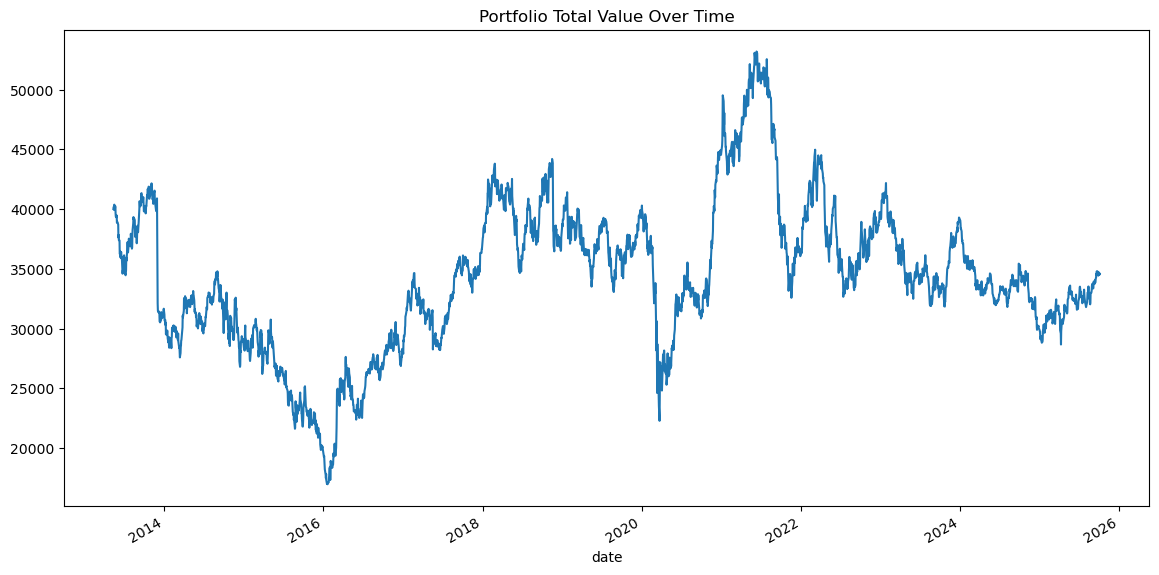

In [10]:
# Plot Portfolio Value
portfolio_total_value['Total'].plot(title='Portfolio Total Value Over Time', figsize=(14, 7))

In [11]:
# Portfolio Performance
total_initial_investment = portfolio_total_value['Total'].iloc[0]
portfolio_total_value['Performance'] = (portfolio_total_value['Total'] - total_initial_investment) / total_initial_investment * 100
display(portfolio_total_value)

# IBOV Performance
benchmark_initial = benchmark.iloc[0]
benchmark['Performance'] = (benchmark - benchmark_initial) / benchmark_initial * 100
display(benchmark)


,ITUB4,ABEV3,VALE3,BBDC3,Total,Performance
date,,,,,,
2013-05-13,10000.000000,10000.000000,10000.000000,10000.000000,40000.000000,0.000000
2013-05-14,10150.014702,10161.690074,9805.622010,9997.098363,40114.425148,0.286063
2013-05-15,10320.582182,10208.898855,9599.282297,10074.365678,40203.129012,0.507823
2013-05-16,10223.493090,10105.039537,9375.000000,10235.152291,39938.684919,-0.153288
2013-05-17,10329.314907,10212.439514,9500.598086,10327.346587,40369.699094,0.924248
...,...,...,...,...,...,...
2025-09-29,11434.872096,1464.652425,17129.186603,4570.826877,34599.538002,-13.501155
2025-09-30,11487.797707,1426.885401,17218.899522,4555.869983,34689.452611,-13.276368
2025-10-01,11276.095266,1415.083205,17437.200957,4466.128617,34594.508046,-13.513730


,IBOV,Performance
date,,
2013-05-13,53.91,0.000000
2013-05-14,53.30,-1.131515
2013-05-15,52.21,-3.153404
2013-05-16,53.78,-0.241143
2013-05-17,54.89,1.817845
...,...,...
2025-09-29,143.45,166.091634
2025-09-30,143.24,165.702096
2025-10-01,142.52,164.366537


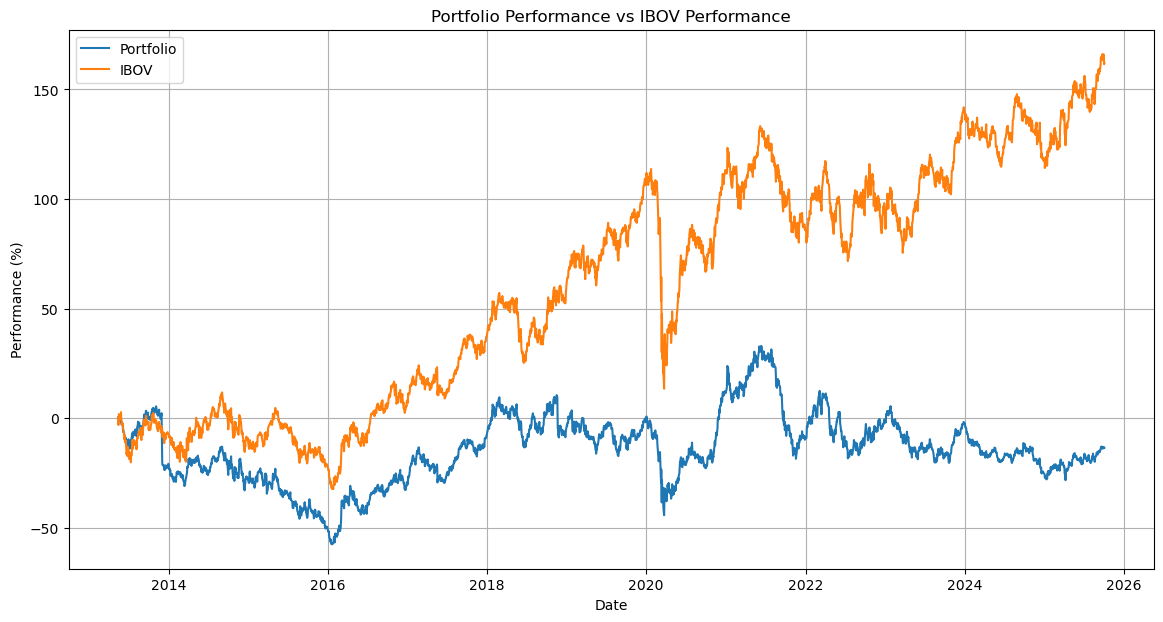

In [12]:
# Plot Portfolio Performance vs IBOV Performance
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(portfolio_total_value.index, portfolio_total_value['Performance'], label='Portfolio')
plt.plot(benchmark.index, benchmark['Performance'], label='IBOV')
plt.title('Portfolio Performance vs IBOV Performance')
plt.xlabel('Date')
plt.ylabel('Performance (%)')
plt.legend()
plt.grid()
plt.show()